## Урок 3. Выбор и обучение модели на отобранных признаках. Сравнение качества и оценка модели

**Содержание:**
* [Сбор и обработка датасетов](#dfs)
* [Сравнение методов обработки датасетов](#feature_selection)
    * [Feature Importance, как атрибут модели](#fi)
    * [Взаимная информация](#mi)
    * [RFE (Recursive Feature Elimination)](#rfe)
    * [Permutation Importance (PI)](#pi)
    * [Качество отобранных признаков  MI, RFE, PI](#mi_rfe_pi)
    * [WoE (Weight of Evidence) and IV (Information Value)](#woe)
    * [ WOE для  Random Forest Clasifier](#rf_woe)
    * [Отбор признаков на основе матрицы корреляций](#corr_features)
* [Оценка качества](#metrics)
    * [Оценка качества базовой модели](#baseline)
    * [Оценка качества прочих моделей](#oth_models)

##### Задание

1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?
2. Обучите любые две другие модели для предсказания оттока для любого из отобранных множеств признаков и сравните качество с уже полученными.
3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.
4. __(*)__ Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте. 

In [121]:
"""Импорт библиотек"""

import time
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb, lightgbm as lgbm, catboost as catb


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix


## Сбор и обработка датасетов
<left><a class="anchor" id="dfs"></a><left>

In [32]:
def time_format(sec):
    return str(timedelta(seconds=sec))

def build_dataset_raw(churned_start_date='2019-01-01',
                      churned_end_date='2019-02-01',
                      inter_list=[(1, 7), (8, 14)],
                      raw_data_path='train/',
                      dataset_path='dataset/',
                      mode='train'):
    start_t = time.time()

    sample = pd.read_csv('{}sample.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    profiles = pd.read_csv('{}profiles.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    payments = pd.read_csv('{}payments.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    reports = pd.read_csv('{}reports.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    abusers = pd.read_csv('{}abusers.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    logins = pd.read_csv('{}logins.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    pings = pd.read_csv('{}pings.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    sessions = pd.read_csv('{}sessions.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    shop = pd.read_csv('{}shop.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')

    print('Run time (reading csv files): {}'.format(time_format(time.time() - start_t)))
    # -----------------------------------------------------------------------------------------------------
    print('NO dealing with outliers, missing values and categorical features...')
    # -----------------------------------------------------------------------------------------------------
    # На основании дня отвала (last_login_dt) строим признаки, которые описывают активность игрока перед уходом

    print('Creating dataset...')
    # Создадим пустой датасет - в зависимости от режима построения датасета - train или test
    if mode == 'train':
        dataset = sample.copy()[['user_id', 'is_churned', 'level', 'donate_total']]
    elif mode == 'test':
        dataset = sample.copy()[['user_id', 'level', 'donate_total']]

    # Пройдемся по всем источникам, содержащим "динамичекие" данные
    for df in [payments, reports, abusers, logins, pings, sessions, shop]:

        # Получим 'day_num_before_churn' для каждого из значений в источнике для определения недели
        data = pd.merge(sample[['user_id', 'login_last_dt']], df, on='user_id')
        data['day_num_before_churn'] = 1 + (data['login_last_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) -
                                            data['log_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))).apply(
            lambda x: x.days)
        df_features = data[['user_id']].drop_duplicates().reset_index(drop=True)

        # Для каждого признака создадим признаки для каждого из времененно интервала (в нашем примере 4 интервала по 7 дней)
        features = list(set(data.columns) - set(['user_id', 'login_last_dt', 'log_dt', 'day_num_before_churn']))
        print('Processing with features:', features)
        for feature in features:
            for i, inter in enumerate(inter_list):
                inter_df = data.loc[data['day_num_before_churn'].between(inter[0], inter[1], inclusive=True)]. \
                    groupby('user_id')[feature].mean().reset_index(). \
                    rename(index=str, columns={feature: feature + '_{}'.format(i + 1)})
                df_features = pd.merge(df_features, inter_df, how='left', on='user_id')

        # Добавляем построенные признаки в датасет
        dataset = pd.merge(dataset, df_features, how='left', on='user_id')

        print('Run time (calculating features): {}'.format(time_format(time.time() - start_t)))

    # Добавляем "статические" признаки
    dataset = pd.merge(dataset, profiles, on='user_id')
    # ---------------------------------------------------------------------------------------------------------------------------
    dataset.to_csv('{}dataset_raw_{}.csv'.format(dataset_path, mode), sep=';', index=False)
    print('Dataset is successfully built and saved to {}, run time "build_dataset_raw": {}'. \
          format(dataset_path, time_format(time.time() - start_t)))

In [33]:

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [34]:
# Следует из исходных данных
CHURNED_START_DATE = '2019-09-01' 
CHURNED_END_DATE = '2019-10-01'

INTER_1 = (1,7)
INTER_2 = (8,14)
INTER_3 = (15,21)
INTER_4 = (22,28)
INTER_LIST = [INTER_1, INTER_2, INTER_3, INTER_4]

In [ ]:
"""Сбор тренеровочного датасета"""

build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='train/',
                  dataset_path='dataset/', 
                  mode='train')

In [35]:
"""Сбор тестового датасета"""

build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='test/',
                  dataset_path='dataset/', 
                  mode='test')

Run time (reading csv files): 0:00:12.067177
NO dealing with outliers, missing values and categorical features...
Creating dataset...
Processing with features: ['pay_amt', 'trans_amt']
Run time (calculating features): 0:00:17.822680
Processing with features: ['reports_amt']
Run time (calculating features): 0:00:44.977567
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:01:54.694611
Processing with features: ['session_amt', 'disconnect_amt']
Run time (calculating features): 0:03:20.161190
Processing with features: ['avg_min_ping']
Run time (calculating features): 0:04:36.340563
Processing with features: ['kd', 'session_player', 'leavings_rate', 'win_rate']
Run time (calculating features): 0:05:46.662758
Processing with features: ['silver_spent', 'gold_spent']
Run time (calculating features): 0:06:59.371444
Dataset is successfully built and saved to dataset/, run time "build_dataset_raw": 0:07:04.273499


In [126]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(sampling_strategy=0.3, random_state=42).fit_sample(X_train, y_train)

Wall time: 20 s


## Сравнение методов обработки датасетов
<left><a class="anchor" id="feature_selection"></a><left>


Существуют различные способы отбора признаков. Рассмотрим некоторые из существующих подходов.

### Feature Importance, как атрибут модели
<left><a class="anchor" id="fi"></a><left>

Некоторые модели, такие как XGBoost, LGBMClassifier, RandomForestRegressor и др., имеют атрибут __feature\_importances\___, который показывает, насколько важен каждый из признаков. Эта "важность" может расчитываться как, например, путем суммирования прироста качества при разбиении узлов дерева по этому признаку, или же равняться количеству разбиений в дереве, которые произошли по данному признаку.

Посмотрим на примере XGBoost, как это выглядит.

Precision: 0.29256712508185984
Recall: 0.4308100289296046
F1: 0.34847893915756634
Log Loss: 0.13420454552962252
ROC AUC: 0.8972855449364763


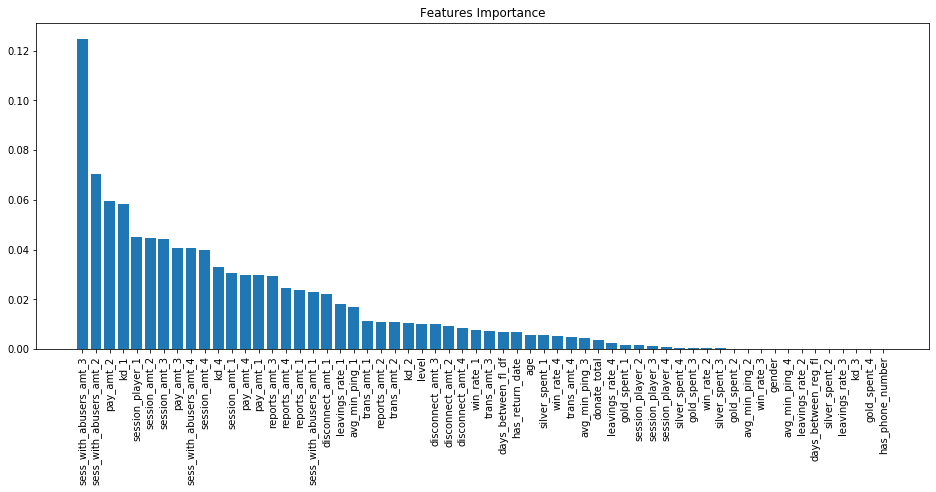

Wall time: 57.2 s


In [41]:
%%time
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance')

Попробуем обучить модель на Топ-30 признаках и оценить качество.

In [42]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_fi = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.29960690480259783
Recall: 0.4226133076181292
F1: 0.3506350635063506
Log Loss: 0.13060046814902213
ROC AUC: 0.8983399762396085
Признаков было: 60
Признаков стало: 30


Видим, что кол-во признаков уменьшили __вдвое__, а качество практически не изменилось.

### Хи-квадрат
<left><a class="anchor" id="chi"></a><left>
    
Данный способ позволяет отбирать признаки, используя статистический тест о зависимости между признаком и целевой переменной. Тест Хи-квадрат применяется в статистике для проверки независиости двух событий. Чем больше значение статистики Хи-квадрат, тем больше сильна завиимости между признаком и таргетом. Рассчитаем статистику и отберем признаки.

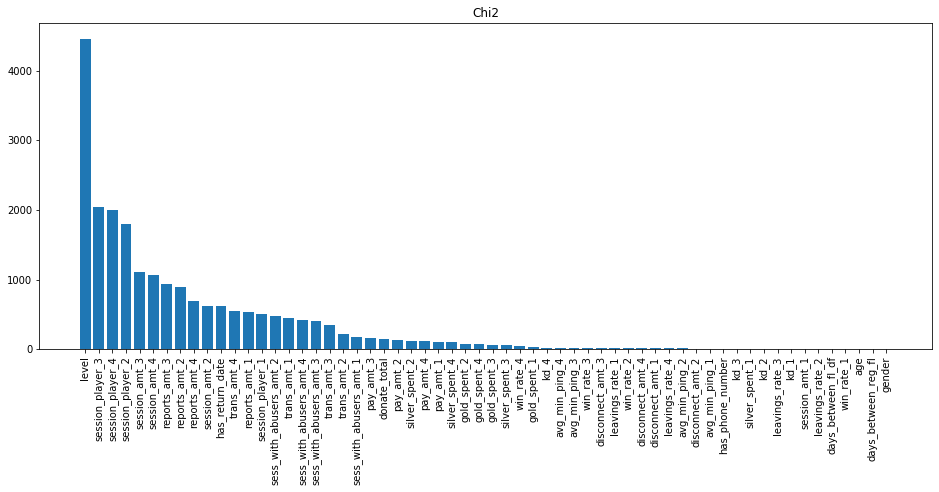

Wall time: 1.92 s


In [45]:
%%time
# Значения в датасете должны быть неотрицательными для расчета Хи квартат
chi2_test = chi2(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(chi2_test[0], X.columns, 'Chi2')

Попробуем обучить модель на Топ-30 признаков и оценить качество.

In [46]:
X_train_CHI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_CHI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_chi = xgb_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)

Precision: 0.28203445447087777
Recall: 0.4144165863066538
F1: 0.33564385433954896
Log Loss: 0.1491679273981847
ROC AUC: 0.8246239983833821


Видим, что на отобранных Хи-квадратом признаках качество упало сильнее, чем при отборе Feature Impotrance модели, но в целом так же незначительно.

### Взаимная информация
<left><a class="anchor" id="mi"></a><left>

Отбор признаков на основании значения [взаимной информации](https://ru.wikipedia.org/wiki/%D0%92%D0%B7%D0%B0%D0%B8%D0%BC%D0%BD%D0%B0%D1%8F_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D1%8F).

In [83]:
%%time
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

Wall time: 15min 5s


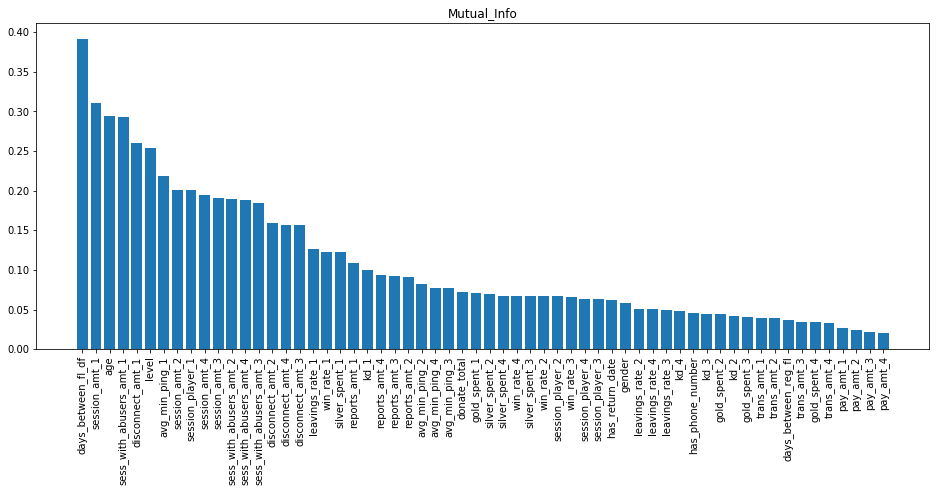

In [87]:
feature_importance_MI = plot_importance(mi, X.columns, 'Mutual_Info')

In [88]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance_MI[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance_MI[0][:30]]

fitted_clf_MI = xgb_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

Precision: 0.29182608695652174
Recall: 0.40453230472516877
F1: 0.33905839563548196
Log Loss: 0.13401004261266553
ROC AUC: 0.8957036748819942


### RFE (Recursive Feature Elimination)
<left><a class="anchor" id="rfe"></a><left>

Рекурскивный отсев признаков - убираем на каждой итерации самые слабые признаки и делаем это до тех пор, пока не увидим заметного снижения качества. На каком кол-ве признаков остановимся, то и считаем оптимальным.

In [78]:
%%time
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features_RFE = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 50
Wall time: 3min


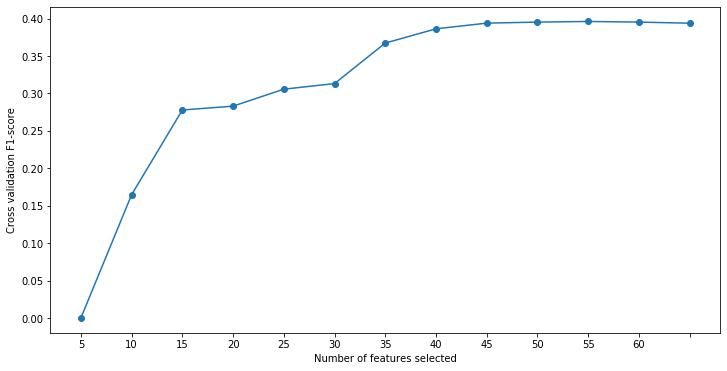

In [79]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [82]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features_RFE]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[good_features_RFE]

fitted_clf_RFE = xgb_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

Precision: 0.2929258241758242
Recall: 0.41128254580520734
F1: 0.34215804251905335
Log Loss: 0.13366767519054526
ROC AUC: 0.8972096945374204


### Permutation Importance (PI)
<left><a class="anchor" id="pi"></a><left>

Перемешивание значений столбца важного признака приводит к заметному снижению качества работы модели

In [51]:
# Модуль можно установить, сделав
# !pip install eli5
# А можно использовать локальный модуль
from ELI5 import PermutationImportance

In [108]:
%%time
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

Wall time: 8min 52s


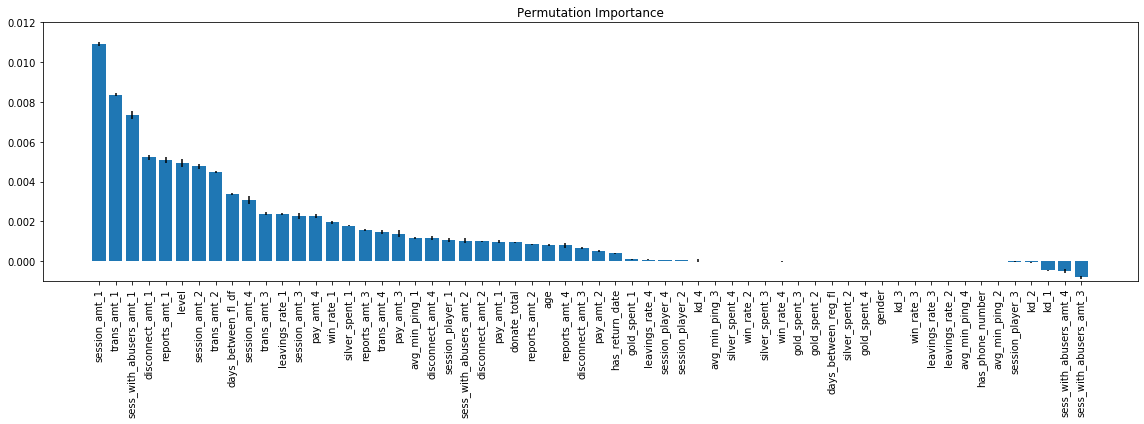

In [109]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.012)
plt.show()

In [110]:
good_features_PI = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

Кол-во отобранных признаков: 44


In [113]:
X_train_PI = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features_PI]
X_test_PI = pd.DataFrame(X_test, columns=X.columns)[good_features_PI]

fitted_clf_PI = xgb_fit_predict(X_train_PI, y_train_balanced, X_test_PI, y_test)

Precision: 0.2897700237906424
Recall: 0.4404532304725169
F1: 0.3495647182626997
Log Loss: 0.13429944302508823
ROC AUC: 0.8987851458435911


### Качество отобранных признаков  MI, RFE, PI
<left><a class="anchor" id="mi_rfe_pi"></a><left>

F1-score:
    
MI - 0.3391  
RFE - 0.3422  
PI - 0.3496

### WoE (Weight of Evidence) and IV (Information Value)
<left><a class="anchor" id="woe"></a><left>

Простое, но в то же время мощное преобразование данных, позволяющее установить монотонную связь между признаками и целевой переменной, а IV может использоваться как мера важности признаков. Преобразование осуществляет корректную обработку как пропущенных значений, так и выбросов, поэтому предварительно обрабатывать датасет не нужно для WOE.

In [89]:
# Для простоты расчетов используем локальный модуль
from WOE_IV import data_vars

dataset_raw = pd.read_csv('dataset/dataset_raw_train.csv', sep=';')
X_raw = dataset_raw.drop(['user_id', 'is_churned'], axis=1)
y_raw = dataset_raw['is_churned']

In [90]:
%%time
# Рассчитаем IV
iv_df, iv = data_vars(X_raw, y_raw)

Wall time: 1min 15s


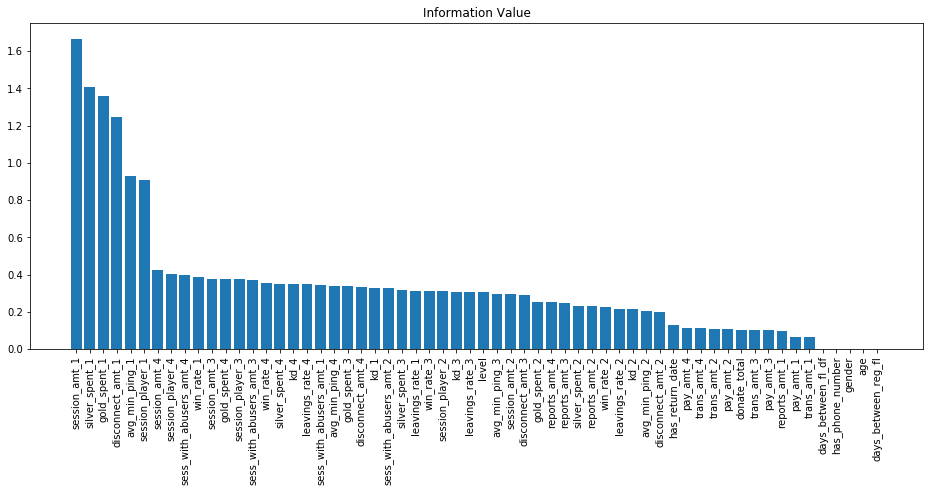

In [91]:
IV = iv.sort_values('IV', ascending=False)
plt.figure(figsize=(16,6))
plt.bar(range(IV.shape[0]), IV['IV'], align='center')
plt.xticks(range(IV.shape[0]), IV['VAR_NAME'].values, rotation=90)
plt.title('Information Value')
plt.show()

In [92]:
%%time
X_WOE = X_raw.copy()

for var in X_WOE.columns:
    small_df = iv_df.loc[iv_df['VAR_NAME'] == var]
    if type(small_df.loc[~small_df['MIN_VALUE'].isnull()]['MIN_VALUE'].values[0]) == str:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 'NaN'
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 'NaN'
    else:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 0.
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 0.
    transform_dict = dict(zip(small_df['MAX_VALUE'], small_df['WOE']))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd += str(i[1]) + ' if x <= ' + str(i[0]) + ' else '
        replace_cmd1 += str(i[1]) + ' if x == "' + str(i[0]) + '" else '
    replace_cmd += '0'
    replace_cmd1 += '0'
    if replace_cmd != '0':
        try:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd))
        except:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd1))

Wall time: 24min 35s


In [94]:
X_train_WOE, X_test_WOE, y_train_WOE, y_test_WOE = train_test_split(X_WOE, 
                                                                    y_raw, 
                                                                    test_size=0.3,
                                                                    shuffle=True, 
                                                                    stratify=y_raw, 
                                                                    random_state=100)
X_train_WOE_balanced, y_train_WOE_balanced = SMOTE(sampling_strategy=0.3, random_state=42).fit_sample(X_train_WOE, y_train_WOE)

In [234]:
# Выделим значимые признаки, для таких признаков IV не должно быть близко ни к 0, ни к 1
significant_features = IV.loc[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME']
print('Значимых признаков:', significant_features.nunique())

Значимых признаков: 49


Из-за установления монотонной связи WOE преобразование тесно связано с логистической регрессией и в некотором смысле "подготавливает" датасет для logit'а. Посмотрим, какое качество получается на WOE датасете у логистической регрессии и сравним это с качеством на "обычном".

In [ ]:
0.2408

In [233]:
%%time
logit = LogisticRegression(random_state=42)
logit.fit(X_train_WOE_balanced, y_train_WOE_balanced)

predict_proba_test = logit.predict_proba(X_test_WOE)
predict_test = logit.predict(X_test_WOE)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, predict_test, predict_proba_test[:, 1])

Precision: 0.2281413376599964
Recall: 0.6101735776277725
F1: 0.3321086471591655
Log Loss: 0.19297949147990973
ROC AUC: 0.8942497388850719
Wall time: 10.7 s


In [97]:
%%time
logit_2 = LogisticRegression(random_state=42)
logit_2.fit(X_train_balanced, y_train_balanced)

predict_proba_test = logit_2.predict_proba(X_test)
predict_test = logit_2.predict(X_test)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.2053025152957172
Recall: 0.29122468659594986
F1: 0.24082934609250398
Log Loss: 0.2570924703893131
ROC AUC: 0.7747174877743964
Wall time: 6.5 s


Как видим, WOE преобразованный датасет позволяет получить на дефолтном logit'е практически такое же качество, как XGBoost! При этом, для сравнения, тот же logit на обычном датасете показывает заметно худшее качество.

### WOE для  Random Forest Clasifier
<left><a class="anchor" id="rf_woe"></a><left>

In [198]:
%%time
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_WOE_balanced, y_train_WOE_balanced)

predict_proba_test = rf.predict_proba(X_test_WOE)
predict_test = rf.predict(X_test_WOE)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, predict_test, predict_proba_test[:, 1])

Precision: 0.43050039714058774
Recall: 0.13066538090646093
F1: 0.20048085814684663
Log Loss: 0.12469477933328978
ROC AUC: 0.8969698243522181
Wall time: 3min 5s


In [199]:
%%time
rf2 = RandomForestClassifier(random_state=42)
rf2.fit(X_train_balanced, y_train_balanced)

predict_proba_test = rf.predict_proba(X_test)
predict_test = rf.predict(X_test)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.028241939279830548
Recall: 0.549662487945998
F1: 0.05372353585692574
Log Loss: 0.7187409157032765
ROC AUC: 0.5239373095957985
Wall time: 6min 2s


In [ ]:
rf_pi = RandomForestClassifier(n_estimators=150, max_depth=4, criterion='entropy', random_state=21)
rf_pi.fit(X_train_PI, y_train_balanced)   
predict_proba_test = rf_pi.predict_proba(X_test_PI)
predict_test = rf_pi.predict(X_test_PI)   
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

**Вывод:**

Технически Random Forest Classifier отработает на преобразованных IV данных, однако качество такой модели будет будет снижено. Information value целесообразно использовать только при построении классификатора на основе логистической регрессии. Это связано с тем, что IV математически соответствует выходным данным логистической регрессии.

IV имеет вид:


$$ IV = \sum{(Event \% - Non Event \%)} \cdot log\frac{Event \%}{Non Event \%}$$

Минимизация логистической функции потерь в общем виде:

$$logit = \log(1 + \exp(-x)) $$

По своей сути WOE является логитом, который также следует из сигмоиды - пороговой функции потерь. Так, на основе IV подбираются признаки, которые имеют наибольшую значимость для модели логистической регрессии.

Модель случайного леса, в отличие от логистической регрессии, является нелинейной (хотя и создается на основе линейных операций). При построении деревьев важность признаков определяется критерием неопределенности Gini, имеющем вид:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}),$$

Таким образом, использование в RF-модели признаков, отсеянных с помощью критерия IV, не будут должным образом согласоваться с Gini impurity, что может привести к потере качества модели за счет исключения имеющих значимость для RF признаков.  

### Отбор признаков на основе матрицы корреляций

<left><a class="anchor" id="corr_features"></a><left>

Хорошие признаки должны иметь высокую корреляцию с целевой переменной, и низкую - между собой

In [129]:
df_corr = pd.DataFrame(X_train_balanced.copy(), columns=X.columns)
df_corr['is_churned'] = y

In [132]:
corr = df_corr.corr()

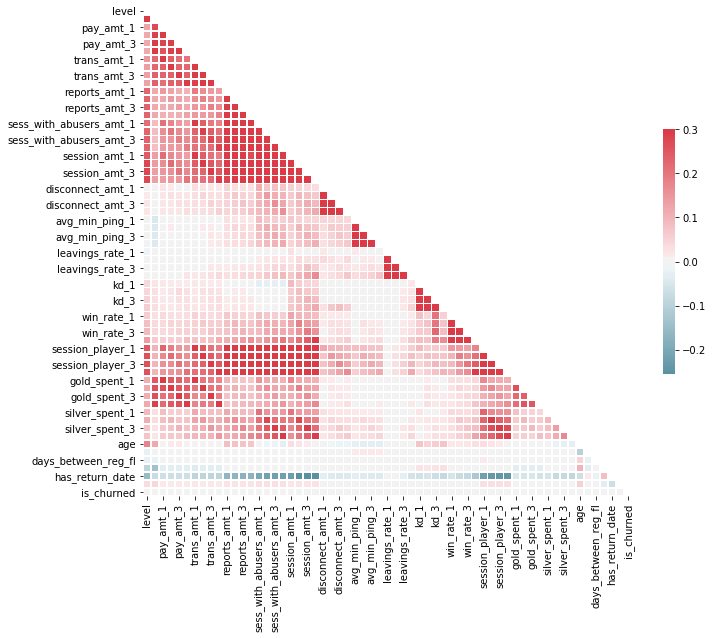

In [142]:
# Plotting a diagonal correlation matrix

mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [192]:
corr_with_target = abs(corr['is_churned']).sort_values(ascending=False)[1:]
good_features_TCF = corr_with_target.index[:35]

In [193]:
# Top Correlated Features model evaluation (TCF)

X_train_TCF = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features_TCF]
X_test_TCF = pd.DataFrame(X_test, columns=X.columns)[good_features_TCF]

fitted_clf_PI = xgb_fit_predict(X_train_TCF, y_train_balanced, X_test_TCF, y_test)

Precision: 0.2819814042962488
Recall: 0.42405978784956605
F1: 0.3387252070094358
Log Loss: 0.13768751242341695
ROC AUC: 0.8866471402329049


F1 на всех признаках: 0.3454

F1 на 35 признаках: 0.3387

F1 на 40 признаков: 0.3485

Вывод: в датасете есть признаки, отрицательно влияющие на работу модели при текущих параметрах

## Оценка качества
<left><a class="anchor" id="metrics"></a><left>

### Оценка качества базовой модели
<left><a class="anchor" id="baseline"></a><left>

В качестве базового решения у нас модель XGBoost. Проведем ее более комплексную оценку, для этого напишем несколько вспомогательных фукнций для более наглядной визуализации результатов.

In [98]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

def plot_PR_curve(y_true, y_pred, y_prob):
    AP = average_precision_score(y_true=y_true, y_score=y_prob)
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_prob)
    
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(AP))
    
def plot_ROC_curve(classifier, X, y, n_folds):
    
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % \
             (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Precision: 0.29256712508185984
Recall: 0.4308100289296046
F1: 0.34847893915756634
Log Loss: 0.13420454552962252
ROC AUC: 0.8972855449364763


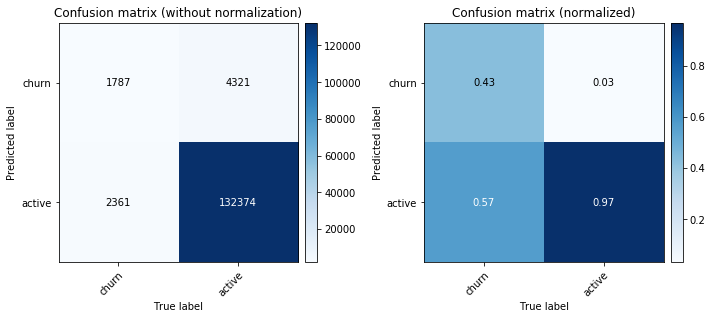

In [99]:
model = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
predict_test = model.predict(X_test)
predict_test_probas = model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()

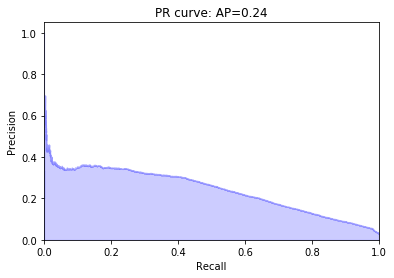

In [100]:
plot_PR_curve(y_test.values, predict_test, predict_test_probas)
plt.show()

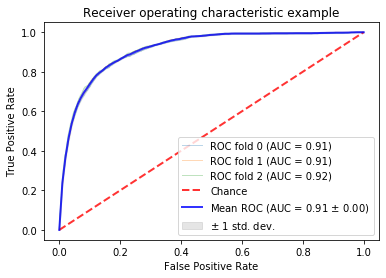

Wall time: 17.8 s


In [101]:
%%time
plot_ROC_curve(classifier=model, 
               X=X_test, 
               y=y_test.values, 
               n_folds=3)

In [ ]:
# Итоговую модель можно сохранить в файл

# with open('models/baseline_xgb.pcl', 'wb') as f:
#     pickle.dump(model, f)

## Оценка качества прочих моделей

<left><a class="anchor" id="oth_models"></a><left>

В качестве входных данных для оценки работы моделей используем признаки, отобранные ранее с помощью Permutation Importance (PI), как показавшие наиболее высокий результат

In [117]:
models = []
models.append(RandomForestClassifier(n_estimators=150, max_depth=4, criterion='entropy', random_state=21))
models.append(GradientBoostingClassifier(max_depth=4, random_state=21))
models.append(KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
models.append(GaussianNB())
models.append(LogisticRegression(random_state=21))
models.append(xgb.XGBClassifier(random_state=21))
models.append(lgbm.LGBMClassifier(random_state=21))
models.append(catb.CatBoostClassifier(silent=True, random_state=21))

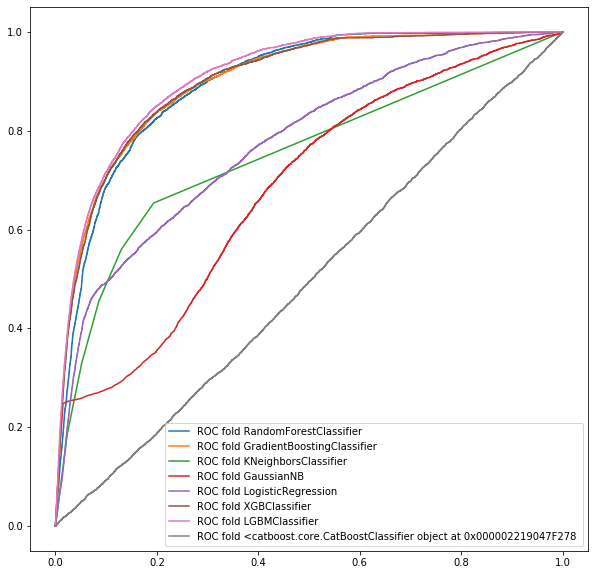

In [118]:
# Вывод Roc curve для каждой модели

plt.figure(figsize=(10, 10)) 
for model in models:
    model.fit(X_train_PI, y_train_balanced)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_PI)[:,1], pos_label=1)
    md = str(model)
    md = md[:md.find('(')]
    plt.plot(fpr, tpr, label='ROC fold %s ' % (md))

plt.legend(loc="lower right")
plt.show()

In [120]:
for model in models:
    print(f'MODEL NAME: {"*"*40} {model.__class__.__name__} {"*"*40}')
    model.fit(X_train_PI, y_train_balanced)   
    predict_proba_test = model.predict_proba(X_test_PI)
    predict_test = model.predict(X_test_PI)   
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
                evaluation(y_test, predict_test, predict_proba_test[:, 1])

MODEL NAME: **************************************** RandomForestClassifier ****************************************
Precision: 0.23663919170433395
Recall: 0.42912246865959497
F1: 0.3050556983718937
Log Loss: 0.1926902144835258
ROC AUC: 0.8942559477608596
MODEL NAME: **************************************** GradientBoostingClassifier ****************************************
Precision: 0.3270761069169557
Recall: 0.38645130183220827
F1: 0.35429329207647253
Log Loss: 0.11812733360088609
ROC AUC: 0.8999836599249615
MODEL NAME: **************************************** KNeighborsClassifier ****************************************
Precision: 0.1388276773909211
Recall: 0.45564127290260364
F1: 0.21281387231167664
Log Loss: 1.256070669866604
ROC AUC: 0.7507225143800597
MODEL NAME: **************************************** GaussianNB ****************************************
Precision: 0.04152453503368972
Recall: 0.8305207328833173
F1: 0.0790944886409294
Log Loss: 11.24393446185758
ROC AUC: 0.68139

Лучший результат **(F1: 0.3559)** показала модель **XGBClassifier**. Модель **LGBM** показала лучший **precision** (0.3804) при текущих параметрах. **Cat boost** получил **наихудшее** качество.

Вероятно, грамотная настройка параметров позволит получить схожие результаты для моделей, основанных на градиентном бустинге.

##### Почему Cat boost получил наихудшее качество?

### Литература


1. [XGBoost Docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
2. [sklearn.feature_selection ](https://scikit-learn.org/stable/modules/feature_selection.html)
3. [Feature Selection with sklearn and Pandas](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)
4. [Weight of evidence and Information Value using Python](https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb)
5. [Weight of Evidence(WOE) and Information Value(IV)](https://www.kaggle.com/pavansanagapati/weight-of-evidence-woe-information-value-iv)